<h2 align=center> Bag of Words</h2>

---

In [ ]:
import nltk

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

cümle = """When I was 17, I read a quote that went something like: If you live
      each day as if it was your last, someday you’ll most certainly be right. 
      It made an impression on me, and since then, for the past 33 years, I have 
      looked in the mirror every morning and asked myself: If today were the 
      last day of my life, would I want to do what I am about to do today? And 
      whenever the answer has been No for too many days in a row, I know 
      I need to change something. """

# Tüm textten cümleleri tokenize et
token_cümle = sent_tokenize(cümle)

cv = CountVectorizer(lowercase=True,stop_words='english')

cümle_sayım = cv.fit_transform(token_cümle)

# Sözlüğümüz ve sıklık dağılımı (tokenized cümlede) 
# print(cv.vocabulary_)
print(cümle_sayım.toarray())

[[1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0]
 [0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 2 1 0 1]
 [0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]]


In [ ]:
token_cümle

['When I was 17, I read a quote that went something like: If you live \n      each day as if it was your last, someday you’ll most certainly be right.',
 'It made an impression on me, and since then, for the past 33 years, I have \n      looked in the mirror every morning and asked myself: If today were the \n      last day of my life, would I want to do what I am about to do today?',
 'And \n      whenever the answer has been No for too many days in a row, I know \n      I need to change something.']

<h2 align=center> NLP için Transfer Learning | TensorFlow Hub</h2>

---

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

plt.rcParams['figure.figsize'] = (12, 8)
from IPython import display

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)

Version:  2.4.1
Hub version:  0.12.0


##  Verinin Yüklenmesi

Eğer siz de veriyi incelemek isterseniz [indirme linki buradadır.](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip).

In [ ]:
url = "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip"

df = pd.read_csv(url, compression='zip')
df.shape

(1306122, 3)

Missing Value yok

* 1306122 entries == 1306122 non-null

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


##### Dağılımı incele

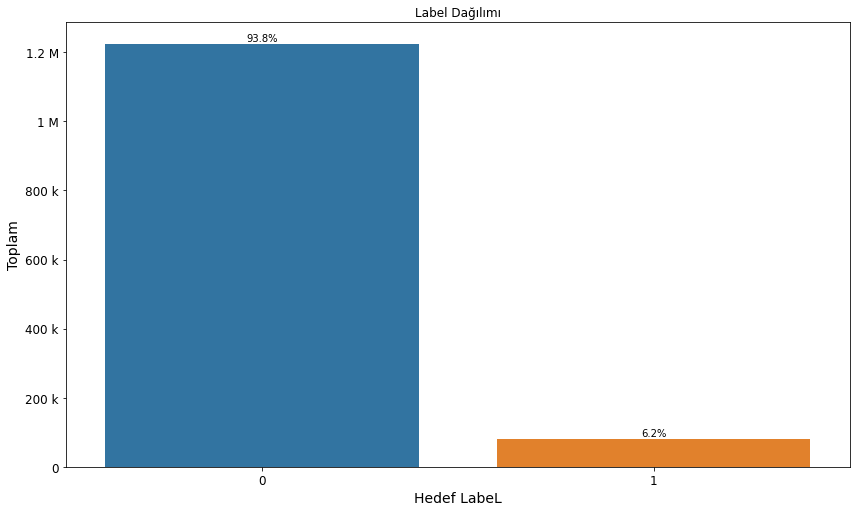

In [ ]:
plt.figure(figsize = (12,7))
ax = sns.countplot(data = df, x = 'target')
plt.xticks(size=12)
plt.xlabel('Hedef LabeL', size = 14)
plt.yticks(size=12)
plt.ylabel('Toplam', size=14)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xticklabels(ax.get_xticklabels(), ha="center")
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.title('Label Dağılımı')
plt.show()

In [ ]:
# Sklearn ile train ve validation setleri

train_df, remaining = train_test_split(df, random_state=13, train_size=0.8, 
                                       stratify=df.target.values)

valid_df, _ = train_test_split(remaining, random_state=13, train_size=0.2, 
                               stratify=remaining.target.values)
train_df.shape, valid_df.shape

((1044897, 3), (52245, 3))

In [ ]:
train_df['target'].value_counts()

0    980249
1     64648
Name: target, dtype: int64

In [ ]:
valid_df['target'].value_counts()

0    49013
1     3232
Name: target, dtype: int64

In [ ]:
total = 1044897
neg = 980249
pos = 64648

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.08


In [ ]:
# Veri setinden örnek cümleler
train_df['question_text'].sample(10).values

array(['How a sun could be blue or green in colour?',
       'What do objectivists think about Elinor Ostrom and her ideas regarding the principles for managing the commmons?',
       'Which machines are used as both motor as well as generator?',
       'Have you ever had a gun pulled on you? Why? And what did it feel like, both during the experience, and then after?',
       'As a Chinese, would it be weird if I use Baymax as my English name?',
       'What is the contribution of Rajendra prsad in agriculture?',
       'How do I write the best cliffhanger for a romantic fiction?',
       'Does North Koreans follows the South Korean serials?',
       'Can an element be broken down further into another substance?',
       'Are there any Good books on parenting?'], dtype=object)

In [ ]:
# Hedef labellara bakalım
train_df['target'].sample(10).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# tf.data kullanmak için tensor_slices methodunu kullanıyoruz. 
# Daha performanslı

train_positive = train_df[train_df['target'] == 1]
train_negative = train_df[train_df['target'] == 0]

pos_ds = tf.data.Dataset.from_tensor_slices((train_positive['question_text'].values,
                      train_positive['target'].values)).shuffle(6400).repeat()

neg_ds = tf.data.Dataset.from_tensor_slices((train_negative['question_text'].values,
                      train_negative['target'].values)).shuffle(98000).repeat()

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], 
                                                         weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(128).prefetch(tf.data.AUTOTUNE)

resampled_ds

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
tf.data.experimental.cardinality(resampled_ds).numpy()

-2

In [ ]:
steps_per_epoch = np.ceil(2.0*pos/128)
steps_per_epoch

1011.0

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,
                                              valid_df['target'].values ))

valid_ds = valid_ds.batch(128).prefetch(tf.data.AUTOTUNE)

valid_ds

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
for sentences, labels in resampled_ds.take(1):
  print(labels.numpy().mean())

0.484375


## TensorFlow Hub

TF Hub sağolsun, hazır train edilmiş modeller sunuyor. Biz şimdilik Text Embedding kullanacağız. [Modullere buradan ulaşabilirsiniz.](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2)

Burada asıl nokta, Transfer Learning kullanmaktır. Bu sayede baştan bir modeli eğitmek yerine, eğitilmiş bir modeli, kendi yapacağımız bir modelin içinde kullanabiliriz vb. Bu şekilde "computation" yapmaktan önemli ölçüde kurtulabiliriz.

## Modelleri Ayarlama Fonksiyonu

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=True):
  # trainable = True yaparsanız embedding eğitebilir olur.

  hub_layer = hub.KerasLayer(module_url, input_shape=[], 
                             output_shape=[embed_size], dtype=tf.string, 
                             trainable=trainable)
  
  model = tf.keras.models.Sequential([
                            hub_layer,
                            tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.TrueNegatives(name='TN'),
                       tf.keras.metrics.TruePositives(name='TP'),
                       tf.keras.metrics.FalseNegatives(name = 'FN'),
                       tf.keras.metrics.FalsePositives(name='FP')])
  model.summary()
  history = model.fit(resampled_ds,
                  epochs=5,
                  validation_data=valid_ds,
                  callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr = 1e-5,
                                                                patience = 2)],
                    verbose=1,
                    steps_per_epoch = steps_per_epoch)

  return history, model

## 5 Farklı Modeli Test Edeceğiz

In [ ]:
histories = {}

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

* Her ModuleURL seçtikten sonra module_url satırını run edin
* histories kısmında isimleri ve embed_size'ları değiştirin :)

--> Callbacklerden dolayı warning çıkarsa ignore edebilirsiniz. Burada amaç, nasıl hub layerlarının nasıl kullanıldığını göstermektir.

In [ ]:
histories['nnlm-en-dim128'], model = train_and_evaluate_model(module_url, 
                                                embed_size=128, 
                                                name='nnlm-en-dim128')

In [ ]:
valid_sonuclar = model.evaluate(valid_ds, verbose=False)
for name, value in zip(model.metrics_names, valid_sonuclar):
  print(name,': ', value)
print()

loss :  0.24138766527175903
binary_accuracy :  0.8967748284339905
precision_1 :  0.3608857989311218
recall_1 :  0.8672648668289185
TN :  44049.0
TP :  2803.0
FN :  429.0
FP :  4964.0



In [ ]:
train_sonuclar = model.evaluate(resampled_ds, verbose=False, 
                                steps = steps_per_epoch)
for name, value in zip(model.metrics_names, train_sonuclar):
  print(name, ': ', value)
print()

loss :  0.1745954304933548
binary_accuracy :  0.9342312812805176
precision_1 :  0.9168432950973511
recall_1 :  0.9552220106124878
TN :  59033.0
TP :  61864.0
FN :  2900.0
FP :  5611.0

